In [47]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'

In [48]:
df=pd.read_csv('Data/sales_predictions.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15       9.3000          Low Fat           0.0160   
1           DRC01       5.9200          Regular           0.0193   
2           FDN15      17.5000          Low Fat           0.0168   
3           FDX07      19.2000          Regular           0.0000   
4           NCD19       8.9300          Low Fat           0.0000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1         3,735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1         2,097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [49]:
## replace inconsistent categories
fat_content_map = {'LF':'Low Fat',
                   'reg':'Regular',
                   'low fat':'Low Fat'}
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(fat_content_map)
## Verify 
df['Item_Fat_Content'].value_counts()


Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [50]:
## Define X and y
target = 'Item_Outlet_Sales'
X = df.drop(columns=target).copy()
y = df[target].copy()
X

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0              FDA15       9.3000          Low Fat           0.0160   
1              DRC01       5.9200          Regular           0.0193   
2              FDN15      17.5000          Low Fat           0.0168   
3              FDX07      19.2000          Regular           0.0000   
4              NCD19       8.9300          Low Fat           0.0000   
5              FDP36      10.3950          Regular           0.0000   
6              FDO10      13.6500          Regular           0.0127   
7              FDP10          NaN          Low Fat           0.1275   
8              FDH17      16.2000          Regular           0.0167   
9              FDU28      19.2000          Regular           0.0944   
10             FDY07      11.8000          Low Fat           0.0000   
11             FDA03      18.5000          Regular           0.0455   
12             FDX32      15.1000          Regular           0.1000   
13             FDS46      17.6000          Regular           0.0473   
14             FDF32      16.3500          Low Fat           0.0680   
15             FDP49       9.0000          Regular           0.0691   
16             NCB42      11.8000          Low Fat           0.0086   
17             FDP49       9.0000          Regular           0.0692   
18             DRI11          NaN          Low Fat           0.0342   
19             FDU02      13.3500          Low Fat           0.1025   
20             FDN22      18.8500          Regular           0.1382   
21             FDW12          NaN          Regular           0.0354   
22             NCB30      14.6000          Low Fat           0.0257   
23             FDC37          NaN          Low Fat           0.0576   
24             FDR28      13.8500          Regular           0.0259   
25             NCD06      13.0000          Low Fat           0.0999   
26             FDV10       7.6450          Regular           0.0667   
27             DRJ59      11.6500          Low Fat           0.0194   
28             FDE51       5.9250          Regular           0.1615   
29             FDC14          NaN          Regular           0.0722   
30             FDV38      19.2500          Low Fat           0.1703   
31             NCS17      18.6000          Low Fat           0.0808   
32             FDP33      18.7000          Low Fat           0.0000   
33             FDO23      17.8500          Low Fat           0.0000   
34             DRH01      17.5000          Low Fat           0.0979   
35             NCX29      10.0000          Low Fat           0.0893   
36             FDV20          NaN          Regular           0.0595   
37             DRZ11       8.8500          Regular           0.1131   
38             FDX10          NaN          Regular           0.1231   
39             FDB34          NaN          Low Fat           0.0265   
40             FDU02      13.3500          Low Fat           0.1025   
41             FDK43       9.8000          Low Fat           0.0268   
42             FDA46      13.6000          Low Fat           0.1178   
43             FDC02      21.3500          Low Fat           0.0691   
44             FDL50      12.1500          Regular           0.0423   
45             FDM39       6.4200          Low Fat           0.0895   
46             NCP05      19.6000          Low Fat           0.0000   
47             FDV49      10.0000          Low Fat           0.0259   
48             FDL12      15.8500          Regular           0.1216   
49             FDS02          NaN          Regular           0.2554   
50             NCL17       7.3900          Low Fat           0.0678   
51             FDM40      10.1950          Low Fat           0.1598   
52             FDR13       9.8950          Regular           0.0287   
53             FDA43      10.8950          Low Fat           0.0650   
54             NCP18      12.1500          Low Fat           0.0288   
55             FDK21       7.

In [51]:
## Drop unwanted/inappropriate columns 
bad_cols = ['Item_Identifier','Outlet_Identifier','Outlet_Establishment_Year']
X = X.drop(columns=bad_cols)
## Perform a train-test-split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [52]:
## Create categorical pipeline
cat_selector = make_column_selector(dtype_include='object')
# create pipeline for handling categorical data
impute_most_freq = SimpleImputer(strategy='most_frequent')
encoder = OneHotEncoder(handle_unknown='ignore',sparse=False)
cat_pipe = make_pipeline(impute_most_freq,encoder)
## Create numeric pipelien
num_selector = make_column_selector(dtype_include='number')
num_selector(X_train)
# create pipeline for handling categorical data
impute_mean = SimpleImputer(strategy='mean')
scaler = StandardScaler()
num_pipe = make_pipeline(impute_mean, scaler)
## Combine into 1 column transformer
preprocessor = make_column_transformer( (cat_pipe,cat_selector),
                                       (num_pipe,num_selector),
                                      verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16de51400>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16de51550>)],
                  verbose_feature_names_out=False)

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error

In [54]:
## Make & Fit the modeling pipeline
pipe = make_pipeline(preprocessor, LinearRegression())
pipe.fit(X_train, y_train)
## Quick peek at the R^2 value for test data
print(f"Training R2: {pipe.score(X_train,y_train) :.3f}")
print(f"Test R2: {pipe.score(X_test,y_test): .3f}")

Training R2: 0.560
Test R2:  0.566


In [57]:
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16de51400>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16de51550>)],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [59]:
feature_names = pipe[0].get_feature_names_out()
coeffs = pd.Series(pipe[-1].coef_, index=feature_names)
coeffs

Item_Fat_Content_Low Fat          27,686,402,626,882,828.0000
Item_Fat_Content_Regular          27,686,402,626,882,792.0000
Item_Type_Baking Goods             1,087,149,177,663,047.6250
Item_Type_Breads                   1,087,149,177,663,031.8750
Item_Type_Breakfast                1,087,149,177,663,099.0000
Item_Type_Canned                   1,087,149,177,663,072.0000
Item_Type_Dairy                    1,087,149,177,662,940.0000
Item_Type_Frozen Foods             1,087,149,177,663,045.6250
Item_Type_Fruits and Vegetables    1,087,149,177,663,087.8750
Item_Type_Hard Drinks              1,087,149,177,663,058.2500
Item_Type_Health and Hygiene       1,087,149,177,663,070.6250
Item_Type_Household                1,087,149,177,663,060.6250
Item_Type_Meat                     1,087,149,177,663,039.7500
Item_Type_Others                   1,087,149,177,663,023.3750
Item_Type_Seafood                  1,087,149,177,663,386.5000
Item_Type_Snack Foods              1,087,149,177,663,025.3750
Item_Typ

In [70]:
top_n = 3
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n).index
plot_vals = coeffs.loc[top_n_features].sort_values()
plot_vals

Outlet_Type_Supermarket Type3    6,627,643,432,620,923.0000
Item_Fat_Content_Regular        27,686,402,626,882,792.0000
Item_Fat_Content_Low Fat        27,686,402,626,882,828.0000
dtype: float64

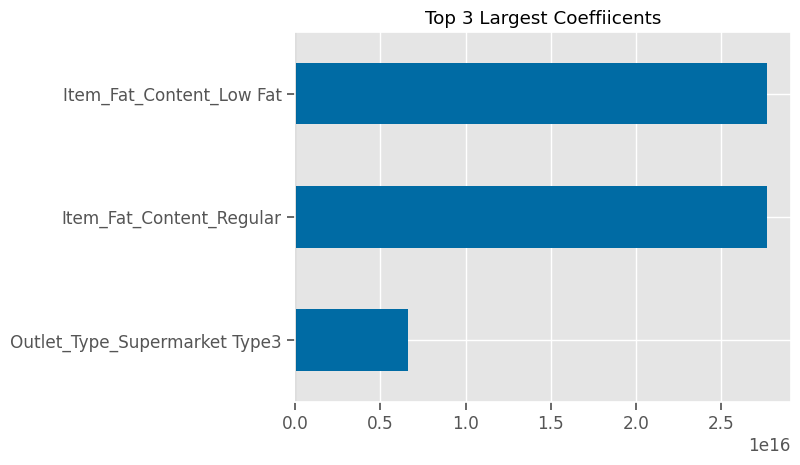

In [71]:
## Plot the coefficients
ax = plot_vals.sort_values().plot(kind='barh')#,figsize=(5,6))
ax.axvline(0,color='k')
plt.savefig('Top_3.png')
ax.set_title(f'Top {top_n} Largest Coeffiicents');

#### All Three of these coefficients indicate that as the predictor variable increases, the response variable also increases.

In [55]:
from sklearn.tree import DecisionTreeRegressor

In [56]:
## Make and fit model
tree_pipe = make_pipeline(preprocessor,DecisionTreeRegressor())
tree_pipe.fit(X_train, y_train)
## Quick peek at the R^2 value for test data
print(f"Training R2: {tree_pipe.score(X_train,y_train) :.3f}")
print(f"Test R2: {tree_pipe.score(X_test,y_test): .3f}")

Training R2: 1.000
Test R2:  0.107


In [61]:
tree_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16de51400>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16de51550>)],
                                   verbose_feature_names_out=False)),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [65]:
feature_names = tree_pipe[0].get_feature_names_out()
coeffs = pd.Series(pipe[-1].coef_, index=feature_names)
coeffs

Item_Fat_Content_Low Fat          27,686,402,626,882,828.0000
Item_Fat_Content_Regular          27,686,402,626,882,792.0000
Item_Type_Baking Goods             1,087,149,177,663,047.6250
Item_Type_Breads                   1,087,149,177,663,031.8750
Item_Type_Breakfast                1,087,149,177,663,099.0000
Item_Type_Canned                   1,087,149,177,663,072.0000
Item_Type_Dairy                    1,087,149,177,662,940.0000
Item_Type_Frozen Foods             1,087,149,177,663,045.6250
Item_Type_Fruits and Vegetables    1,087,149,177,663,087.8750
Item_Type_Hard Drinks              1,087,149,177,663,058.2500
Item_Type_Health and Hygiene       1,087,149,177,663,070.6250
Item_Type_Household                1,087,149,177,663,060.6250
Item_Type_Meat                     1,087,149,177,663,039.7500
Item_Type_Others                   1,087,149,177,663,023.3750
Item_Type_Seafood                  1,087,149,177,663,386.5000
Item_Type_Snack Foods              1,087,149,177,663,025.3750
Item_Typ

In [76]:
top_n = 5
coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
top_n_features = coeff_rank.head(top_n).index
plot_vals = coeffs.loc[top_n_features].sort_values()
plot_vals

Outlet_Type_Supermarket Type2    6,627,643,432,619,216.0000
Outlet_Type_Supermarket Type1    6,627,643,432,619,494.0000
Outlet_Type_Supermarket Type3    6,627,643,432,620,923.0000
Item_Fat_Content_Regular        27,686,402,626,882,792.0000
Item_Fat_Content_Low Fat        27,686,402,626,882,828.0000
dtype: float64

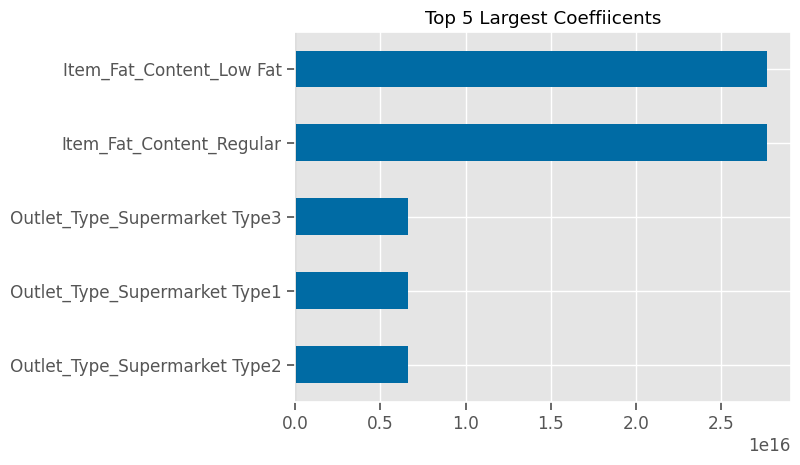

In [77]:
## Plot the coefficients
ax = plot_vals.sort_values().plot(kind='barh')#,figsize=(5,6))
ax.axvline(0,color='k')
plt.savefig('Top_5.png')
ax.set_title(f'Top {top_n} Largest Coeffiicents');

In [74]:
## Make & Fit the modeling pipeline
pipe = make_pipeline(preprocessor, LinearRegression())
pipe.fit(X_train, y_train)
## Quick peek at the R^2 value for test data
print(f"Training R2: {pipe.score(X_train,y_train) :.3f}")
print(f"Test R2: {pipe.score(X_test,y_test): .3f}")

Training R2: 0.560
Test R2:  0.566


In [78]:
## saving variables for next lesson/notebook
import joblib
## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train': y_train,
         'X_test':X_test_df,
          "y_test": y_test,
         'preprocessor':preprocessor,
         'RandomForest':pipe}
joblib.dump(export, 'linear_regression_l01.joblib')

['linear_regression_l01.joblib']